# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [1]:
import io
import numpy as np

from skimage import data
from skimage import io
from skimage import exposure
from skimage.color import rgb2gray

io.imshow(data.coins());

image = data.coins()
image_gray = rgb2gray(image)

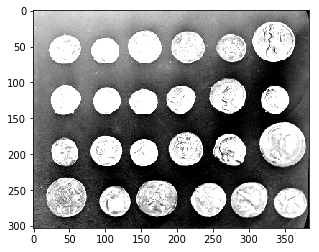

In [2]:
from skimage import exposure
%matplotlib inline
import matplotlib.pyplot as plt

coins_equal = exposure.rescale_intensity(image_gray, in_range=(30, 150))
plt.imshow(coins_equal, cmap='gray');

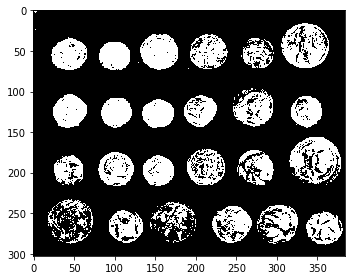

In [3]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(coins_equal)
binary = image > thresh

io.imshow(binary)

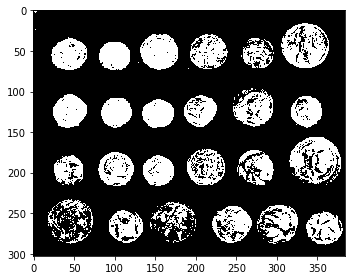

In [4]:
from skimage.segmentation import clear_border

clear_border = clear_border(binary)
io.imshow(clear_border)

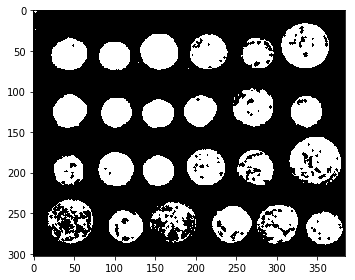

In [5]:
from skimage.morphology import closing

morph = closing(clear_border)
io.imshow(morph)

In [6]:
from skimage.measure import regionprops, label
from skimage.color import label2rgb

morph_new = label(morph)
region_props = regionprops(morph_new)

In [7]:
import numpy as np

coordinates = []
areas = []
eccentricities = []

for props in region_props:
    y0, x0 = props.centroid
    major_axis = props.major_axis_length
    minor_axis = props.minor_axis_length
    area = 2*np.pi*major_axis*minor_axis
    areas.append(area)
    eccentricity = np.sqrt(major_axis**2 - minor_axis**2)/major_axis
    eccentricities.append(eccentricity)
    coordinates.append([x0,y0])

sorted_coordinates = [x for _,x in sorted(zip(areas, coordinates))]
sorted_areas = sorted(areas)
sorted_eccentricities = [x for _,x in sorted(zip(areas, eccentricities))]

coin_coordinates = np.array(sorted_coordinates[-24:])
coin_areas = np.array(sorted_areas[-24:])
coin_eccentricities = np.array(sorted_eccentricities[-24:])


/Users/sarafinanance/anaconda/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


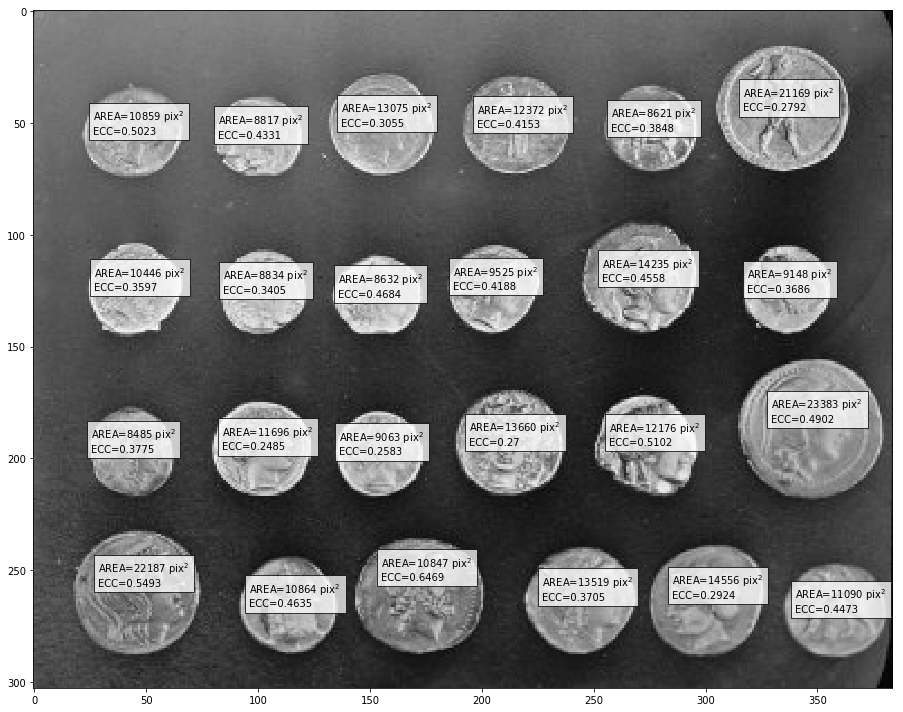

In [8]:
plt.figure(figsize = (15,10))
io.imshow(image)
for i in range(len(coin_areas)):
    x0 = coin_coordinates.T[0][i] -18
    y0 = coin_coordinates.T[1][i]
    area = str(int(coin_areas[i]))
    eccentricity = str(round(coin_eccentricities[i], 4))
    plt.text(x0, y0, "AREA="+area+" pix$^2$ \nECC="+eccentricity,
             bbox={'facecolor':'white', 'alpha':0.75}, color="black", fontsize=10)

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

In [9]:
from __future__ import division, print_function
%matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

In [11]:
import skimage.io as io

pano_imgs = io.ImageCollection('images/*.jpg')

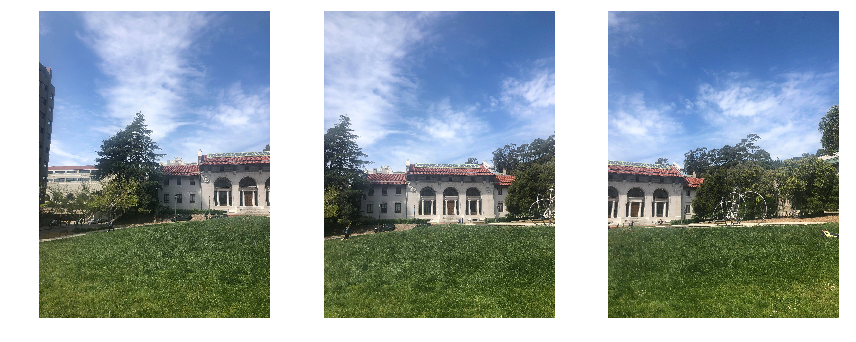

In [12]:
compare(*pano_imgs, figsize=(12, 10))

In [13]:
from skimage.color import rgb2gray

pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs]

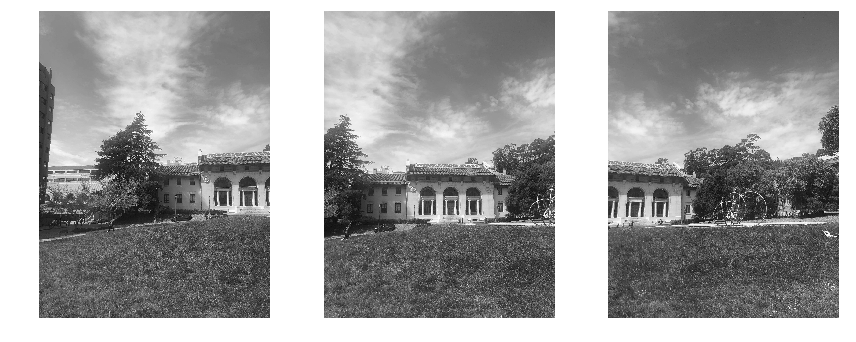

In [14]:
# View the results
compare(pano0, pano1, pano2, figsize=(12, 10))

In [15]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

In [16]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

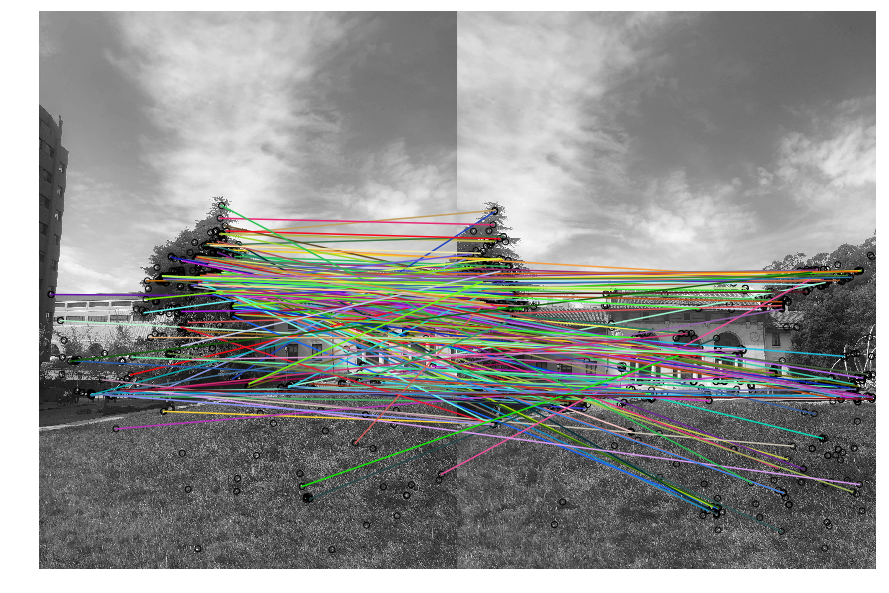

In [17]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01)
ax.axis('off');

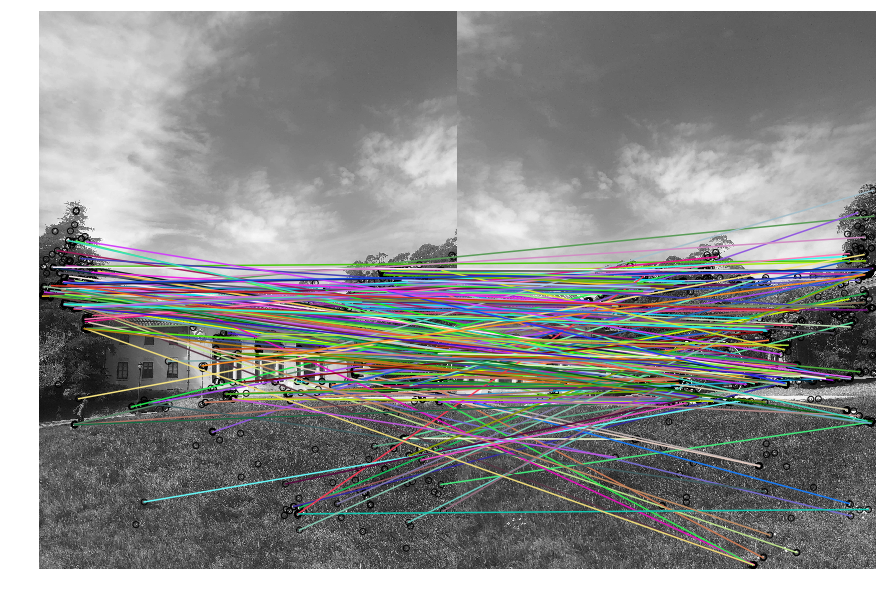

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12)
ax.axis('off');

In [19]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

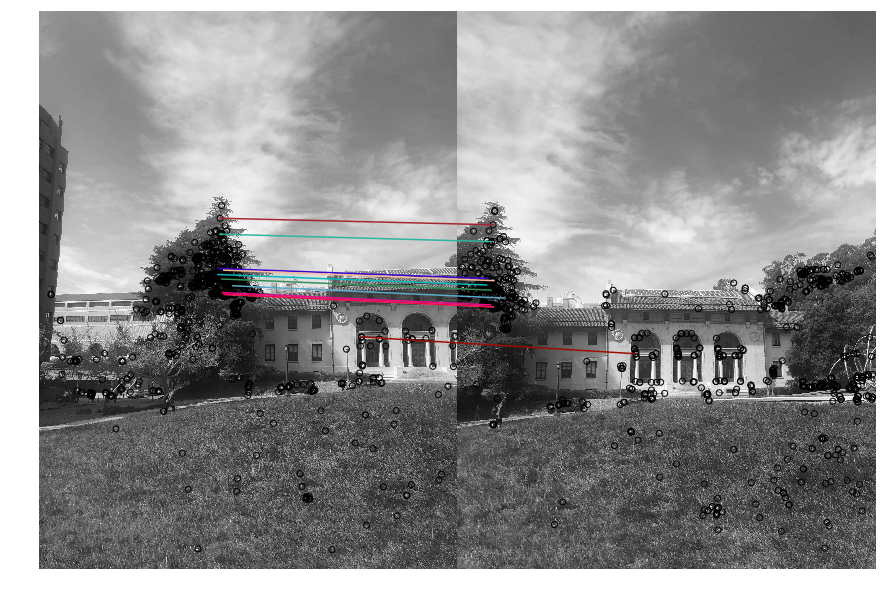

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');

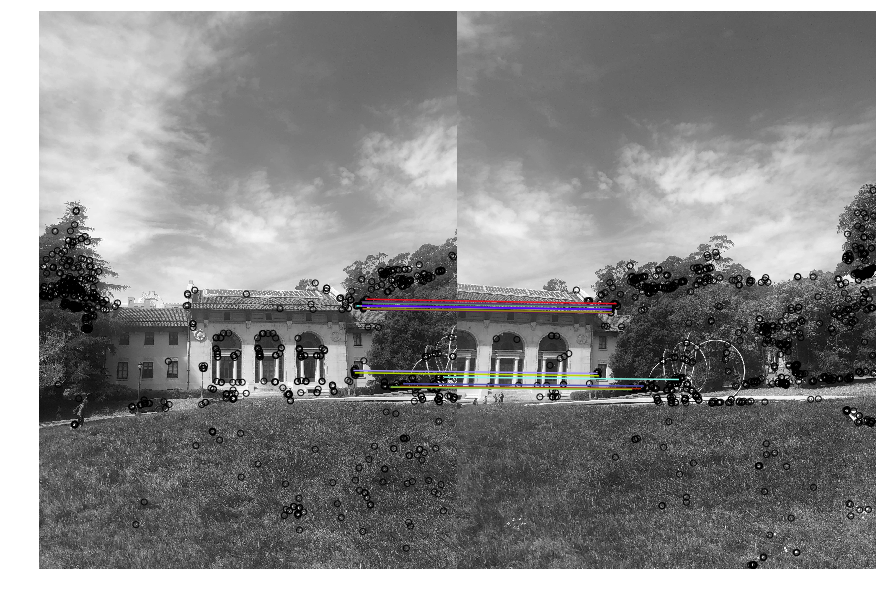

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])

ax.axis('off');

In [22]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

In [23]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

In [24]:
# Warp pano0 (left) to pano1
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

In [25]:
# Warp pano2 (right) to pano1 
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

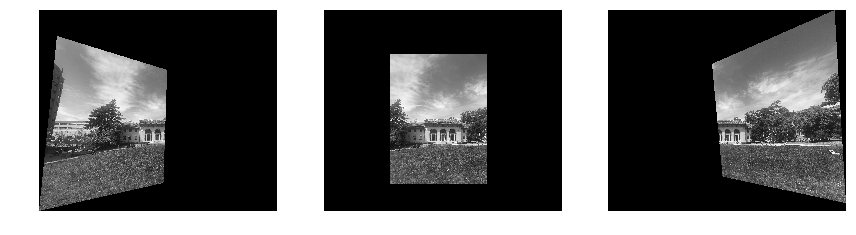

In [26]:
compare(pano0_warped, pano1_warped, pano2_warped, figsize=(12, 10));

In [27]:
# Add the three images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (pano0_warped + pano1_warped + pano2_warped)

In [28]:
# Track the overlap by adding the masks together
overlap = (pano0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           pano1_mask + 
           pano2_mask)

In [29]:
# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

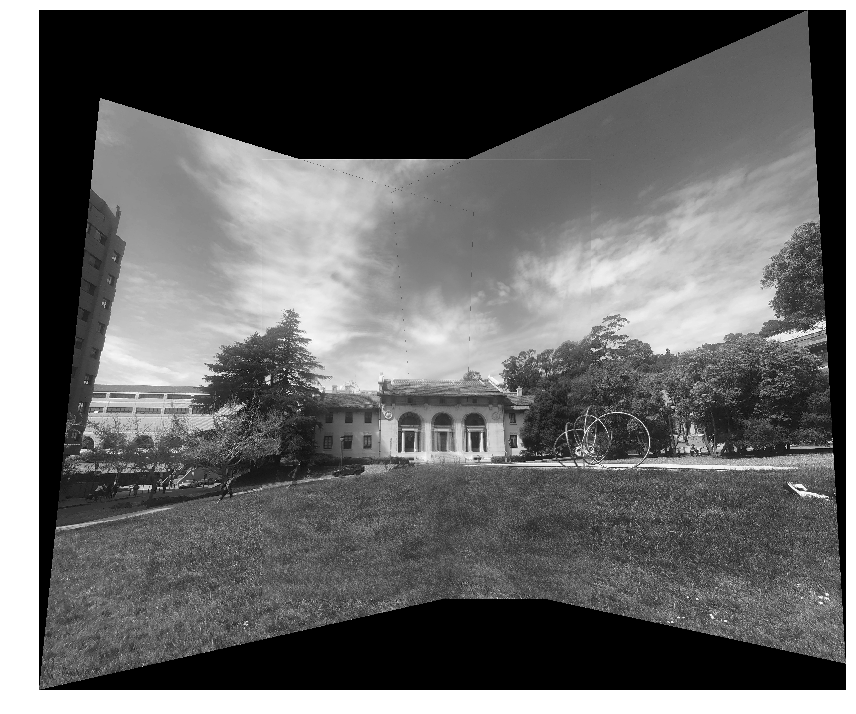

In [30]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

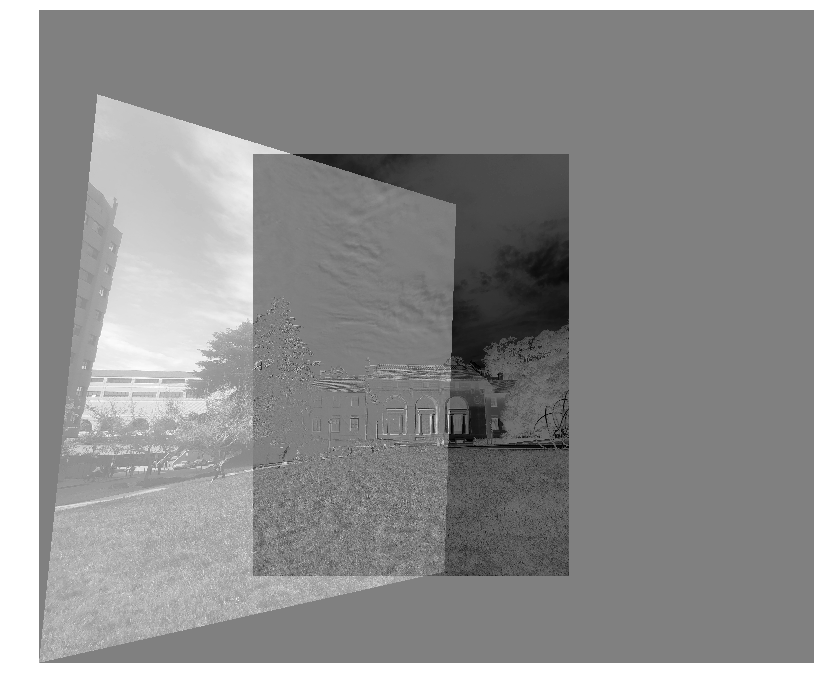

In [31]:
fig, ax = plt.subplots(figsize=(15,12))

# Generate difference image and inspect it
difference_image = pano0_warped - pano1_warped
ax.imshow(difference_image, cmap='gray')

ax.axis('off');

In [32]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

In [33]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

In [34]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

In [35]:
costs01[0,  :] = 0
costs01[-1, :] = 0

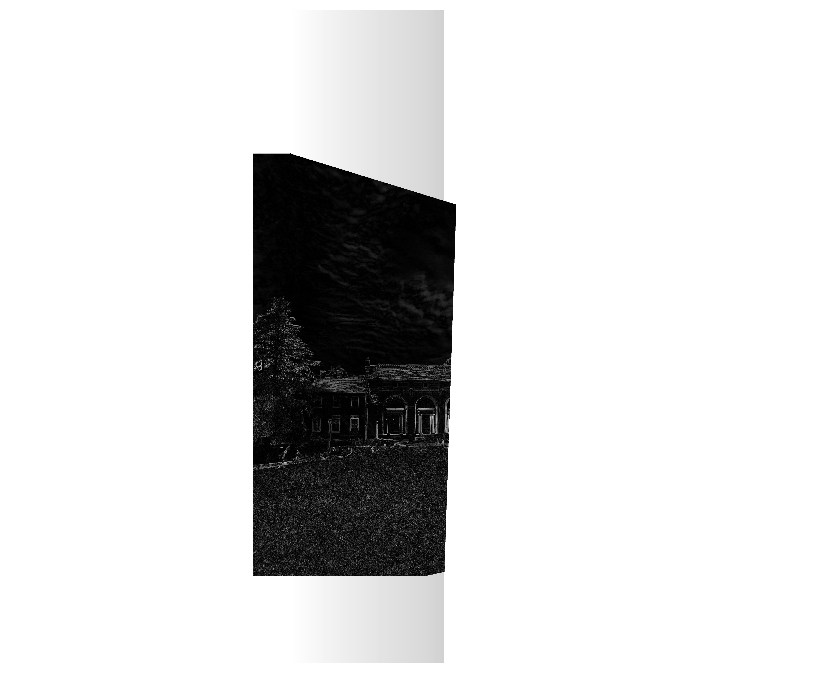

In [36]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.imshow(costs01, cmap='gray', interpolation='none')

ax.axis('off');

In [37]:
from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

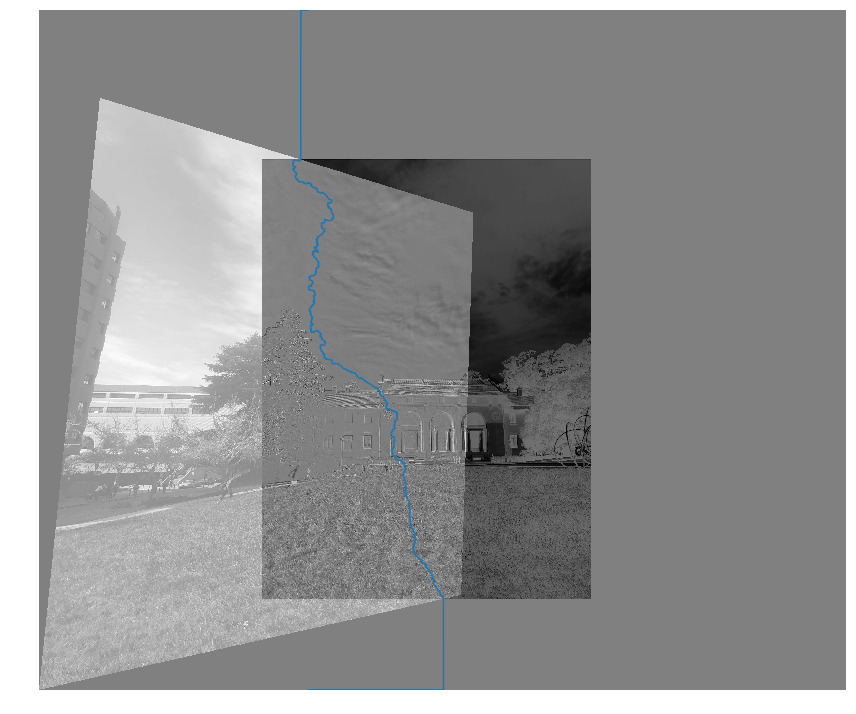

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

In [39]:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

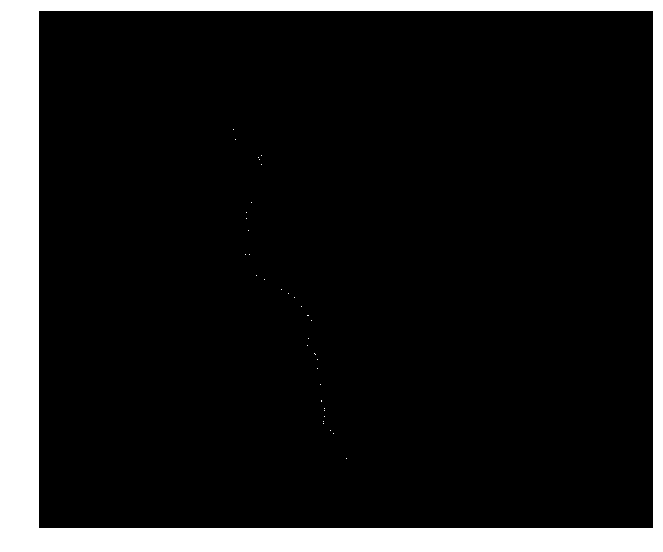

In [40]:
fig, ax = plt.subplots(figsize=(11, 11))

# View the path in black and white
ax.imshow(mask0, cmap='gray')

ax.axis('off');

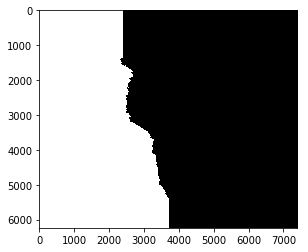

In [41]:
from skimage.measure import label

# Labeling starts with one at point (0, 0)
mask0 = (label(mask0, connectivity=1, background=-1) == 1)

# The result
plt.imshow(mask0, cmap='gray');

In [42]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

In [43]:
costs12[mask0 > 0] = 1

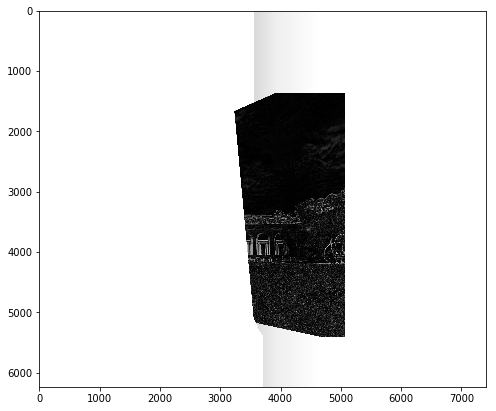

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');

In [45]:
# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

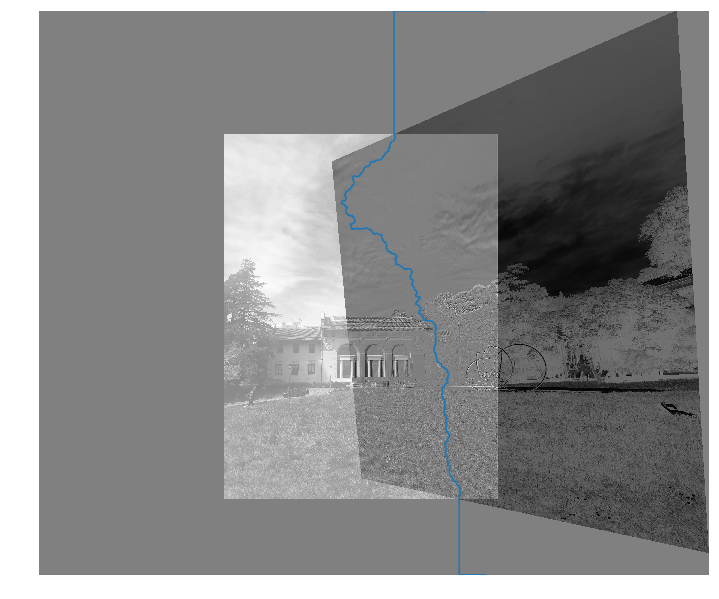

In [46]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');

In [47]:
mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

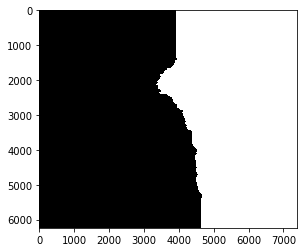

In [48]:
mask2 = (label(mask2, connectivity=1, background=-1) == 3)

# The result
plt.imshow(mask2, cmap='gray');

In [49]:
mask1 = ~(mask0 | mask2).astype(bool)

In [50]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

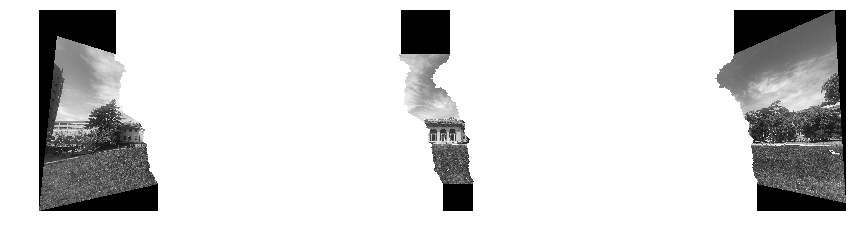

In [51]:
pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)

compare(pano0_final, pano1_final, pano2_final, figsize=(12, 12))

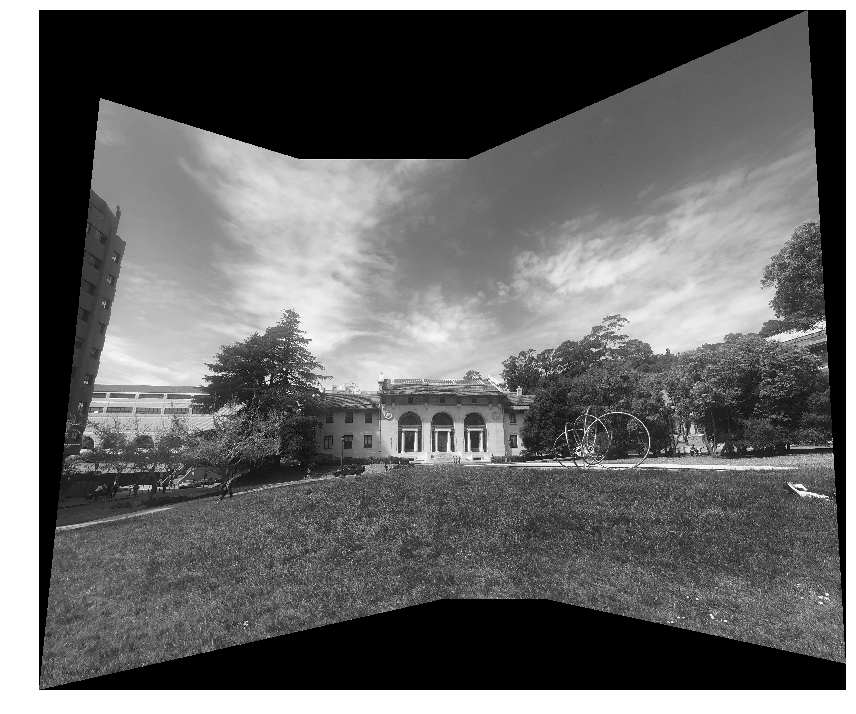

In [52]:
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

In [53]:
# Identical transforms as before, except
#   * Operating on original color images
#   * filling with cval=0 as we know the masks
pano0_color = warp(pano_imgs[0], (model_robust01 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano1_color = warp(pano_imgs[1], offset1.inverse, order=3,
                   output_shape=output_shape, cval=0)

pano2_color = warp(pano_imgs[2], (model_robust12 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

In [54]:
pano0_final = add_alpha(pano0_color, mask0)
pano1_final = add_alpha(pano1_color, mask1)
pano2_final = add_alpha(pano2_color, mask2)

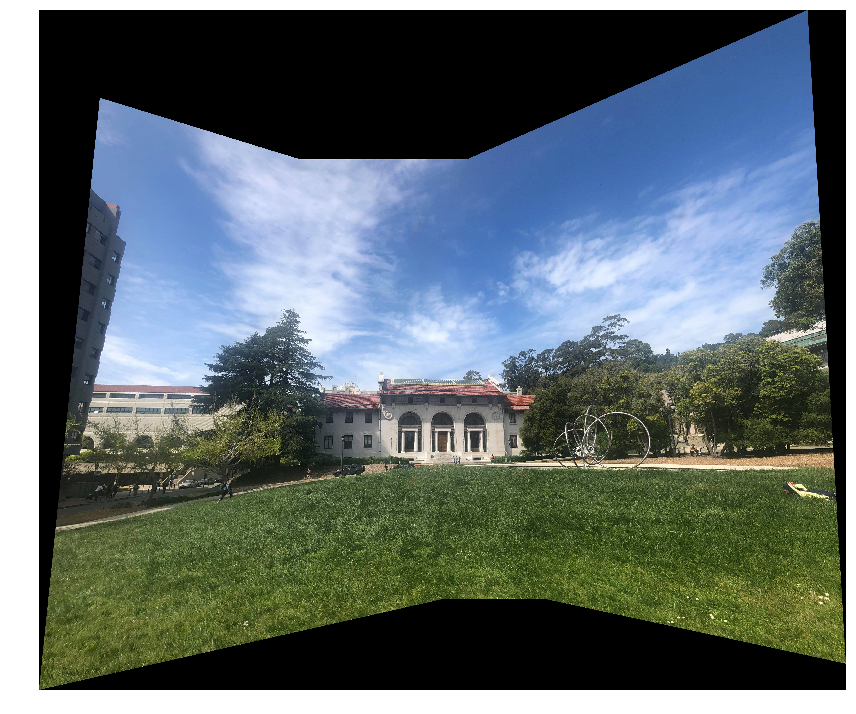

In [55]:
fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

Beautifully rendered pano of the building outside Campbell! :) 